In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import talib
import sys
import os
sys.path.append(os.path.abspath(".."))  # if you're inside notebooks/

from scripts.news_utils import (
    load_news_data,
    parse_dates,
    filter_by_ticker,
    daily_article_counts,
    plot_daily_article_frequency
)

In [3]:
ticker = 'NVDA'
news_path = '../data/raw_analyst_ratings.csv'
stock_path = f'../data/yfinance_data/{ticker}_historical_data.csv'

# ------------------ Load & Preprocess News Data ------------------
df_news = load_news_data(news_path)
df_news = parse_dates(df_news)
df_news_nvda = filter_by_ticker(df_news, ticker)

print("\nNVDA News Data Info:")
print(df_news_nvda.info())


NVDA News Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 3146 entries, 924271 to 927416
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   headline   3146 non-null   object             
 1   url        3146 non-null   object             
 2   publisher  3146 non-null   object             
 3   date       3146 non-null   datetime64[ns, UTC]
 4   stock      3146 non-null   object             
 5   date_only  3146 non-null   object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 172.0+ KB
None


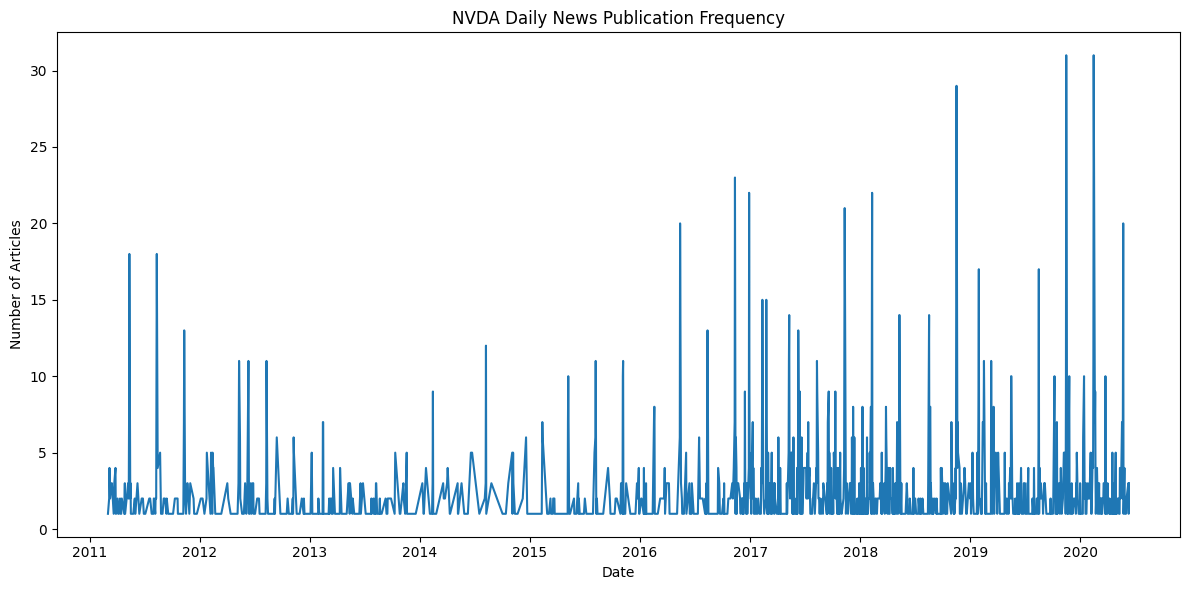


NVDA Stock Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3374 entries, 2011-03-03 to 2024-07-30
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3374 non-null   float64
 1   High          3374 non-null   float64
 2   Low           3374 non-null   float64
 3   Close         3374 non-null   float64
 4   Adj Close     3374 non-null   float64
 5   Volume        3374 non-null   int64  
 6   Dividends     3374 non-null   float64
 7   Stock Splits  3374 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 237.2 KB
None


/tmp/ipykernel_5553/3281135324.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2020-06-10 16:37:10', '2020-06-10 16:12:25', '2020-06-10 14:22:11',
 '2020-06-09 17:40:43', '2020-06-08 16:30:29', '2020-06-08 14:53:46',
 '2020-06-08 13:47:06', '2020-06-02 17:20:06', '2020-06-02 11:14:40',
 '2020-05-31 15:05:12',
 ...
 '2011-03-09 00:00:00', '2011-03-09 00:00:00', '2011-03-09 00:00:00',
 '2011-03-08 00:00:00', '2011-03-08 00:00:00', '2011-03-08 00:00:00',
 '2011-03-08 00:00:00', '2011-03-07 00:00:00', '2011-03-07 00:00:00',
 '2011-03-03 00:00:00']
Length: 3146, dtype: datetime64[ns]' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  df_news_nvda.loc[:, 'date'] = pd.to_datetime(df_news_nvda['date'], utc=True).dt.tz_localize(None)


In [5]:
# ------------------ Visualize News Frequency ------------------
daily_counts = daily_article_counts(df_news_nvda)
plot_daily_article_frequency(daily_counts, title=f'{ticker} Daily News Publication Frequency')

# ------------------ Load Stock Price Data ------------------
df_stock = pd.read_csv(stock_path)
df_news_nvda.loc[:, 'date'] = pd.to_datetime(df_news_nvda['date'], utc=True).dt.tz_localize(None)


df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock.set_index('Date', inplace=True)
df_stock = df_stock[df_stock.index >= df_news_nvda['date'].min()]  # Align with news

print("\nNVDA Stock Data Info:")
print(df_stock.info())

In [6]:
# ------------------ Technical Indicators ------------------
df_stock['SMA_20'] = talib.SMA(df_stock['Close'], timeperiod=20)
df_stock['EMA_20'] = talib.EMA(df_stock['Close'], timeperiod=20)
df_stock['RSI'] = talib.RSI(df_stock['Close'], timeperiod=14)
df_stock['MACD'], df_stock['MACD_Signal'], df_stock['MACD_Hist'] = talib.MACD(
    df_stock['Close'], fastperiod=12, slowperiod=26, signalperiod=9
)

In [7]:
# ------------------ Financial Metrics ------------------
df_stock['Daily_Return'] = df_stock['Close'].pct_change() * 100
df_stock['Volatility'] = df_stock['Daily_Return'].rolling(window=20).std()


NVDA with Indicators and Metrics:
                 Close    SMA_20        RSI  Daily_Return      MACD  \
Date                                                                  
2024-07-24  114.250000  124.9165  41.589800     -6.803162 -0.007652   
2024-07-25  112.279999  124.2105  39.943932     -1.724290 -0.817813   
2024-07-26  113.059998  123.6640  40.940507      0.694691 -1.381013   
2024-07-29  111.589996  123.0665  39.606589     -1.300196 -1.923793   
2024-07-30  103.730003  122.0380  33.349720     -7.043636 -2.954132   

            MACD_Signal  MACD_Hist  
Date                                
2024-07-24     1.879233  -1.886885  
2024-07-25     1.339824  -2.157637  
2024-07-26     0.795656  -2.176669  
2024-07-29     0.251767  -2.175559  
2024-07-30    -0.389413  -2.564719  


/tmp/ipykernel_5553/3696331987.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/smuca/task/news_impact_price_analysis/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


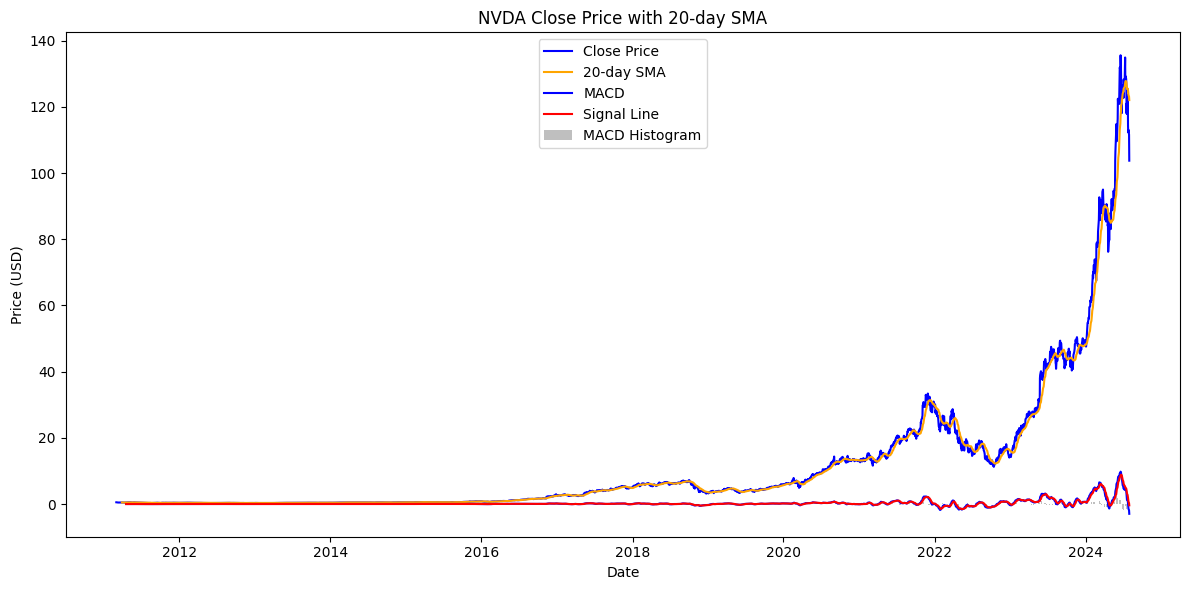

In [8]:
# ------------------ Inspect & Visualize ------------------
print("\nNVDA with Indicators and Metrics:")
print(df_stock[['Close', 'SMA_20', 'RSI', 'Daily_Return', 'MACD', 'MACD_Signal', 'MACD_Hist']].tail())


# Plot Close Price with SMA
plt.figure(figsize=(12, 6))
plt.plot(df_stock['Close'], label='Close Price', color='blue')
plt.plot(df_stock['SMA_20'], label='20-day SMA', color='orange')
plt.plot(df_stock.index, df_stock['MACD'], label='MACD', color='blue')
plt.plot(df_stock.index, df_stock['MACD_Signal'], label='Signal Line', color='red')
plt.bar(df_stock.index, df_stock['MACD_Hist'], label='MACD Histogram', color='gray', alpha=0.5)


plt.title(f'{ticker} Close Price with 20-day SMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()